In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import warnings

In [ ]:
def load_and_clean_datasets(sqli_path, xss_path):

    sqli_df = pd.read_csv(sqli_path, on_bad_lines='skip')
    
    clean_rows = []
    for _, row in sqli_df.iterrows():
        values = [v for v in row.tolist() if pd.notnull(v)]
        if len(values) < 2:
            continue
        label = values[-1]
        sentence = ", ".join([str(v) for v in values[:-1]])
        if str(label) in ['0', '1', '0.0', '1.0']:
            clean_label = 'SQLi' if int(float(label)) == 1 else 'Benign'
            clean_rows.append({'Sentence': sentence, 'Label': clean_label})

    df_sqli_clean = pd.DataFrame(clean_rows)
    print(f"SQLi Loaded & Cleaned: {len(df_sqli_clean)} rows")

    xss_df = pd.read_csv(xss_path)
    xss_df['Label'] = xss_df['Label'].apply(lambda x: 'XSS' if x == 1 else 'Benign')
    df_xss_clean = xss_df[['Sentence', 'Label']]
    print(f"XSS Loaded: {len(df_xss_clean)} rows")

    full_df = pd.concat([df_sqli_clean, df_xss_clean], ignore_index=True)
    full_df.drop_duplicates(subset=['Sentence'], inplace=True)

    print(f"Final Merged Dataset: {len(full_df)} unique samples")
    return full_df


In [ ]:
def add_analysis_features(df):
    df['Length'] = df['Sentence'].astype(str).apply(len)
    special_chars = set('\'"<>;--/*%()')
    df['Special_Char_Count'] = df['Sentence'].apply(lambda x: sum(1 for c in str(x) if c in special_chars))
    return df



In [ ]:
def plot_eda(df):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    sns.countplot(x='Label', data=df, palette='viridis')
    plt.title('Distribution of Attack Types')
    plt.xlabel('Class')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    sns.boxplot(x='Label', y='Length', data=df, palette='coolwarm')
    plt.yscale('log')
    plt.title('Payload Length Distribution (Log Scale)')
    plt.ylabel('Length (Characters)')

    plt.subplot(1, 3, 3)
    sns.boxplot(x='Label', y='Special_Char_Count', data=df, palette='magma')
    plt.yscale('log')
    plt.title('Special Character Usage (Log Scale)')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_ngrams(df, label_type, n=3, top_k=10):
    subset = df[df['Label'] == label_type]['Sentence'].astype(str)
    vec = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=True)
    matrix = vec.fit_transform(subset)
    counts = matrix.sum(axis=0)
    
    ngram_freq = [(word, counts[0, idx]) for word, idx in vec.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    
    print(f"\n--- Top {top_k} {n}-grams for {label_type} ---")
    for gram, freq in ngram_freq[:top_k]:
        print(f"'{gram}': {freq}")


SQLi Loaded & Cleaned: 30919 rows
XSS Loaded: 13686 rows
Final Merged Dataset: 41817 unique samples

 Class Counts:
Label
Benign    23118
SQLi      11376
XSS        7323
Name: count, dtype: int64

 Sample Data:
                                            Sentence Label  Length  \
0                  " or pg_sleep  (  __TIME__  )  --  SQLi      33   
1  create user name identified by pass123 tempora...  SQLi      89   
2   AND 1  =  utl_inaddr.get_host_address   (    ...  SQLi     218   
3   select * from users where id  =  '1' or @ @1 ...  SQLi      90   
4   select * from users where id  =  1 or 1#"  ( ...  SQLi      85   

   Special_Char_Count  
0                   5  
1                   0  
2                  13  
3                   8  
4                   7  


C:\Users\abhay\AppData\Local\Temp\ipykernel_8832\4043449863.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')
C:\Users\abhay\AppData\Local\Temp\ipykernel_8832\4043449863.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Length', data=df, palette='coolwarm')
C:\Users\abhay\AppData\Local\Temp\ipykernel_8832\4043449863.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Special_Char_Count', data=df, palette='magma')


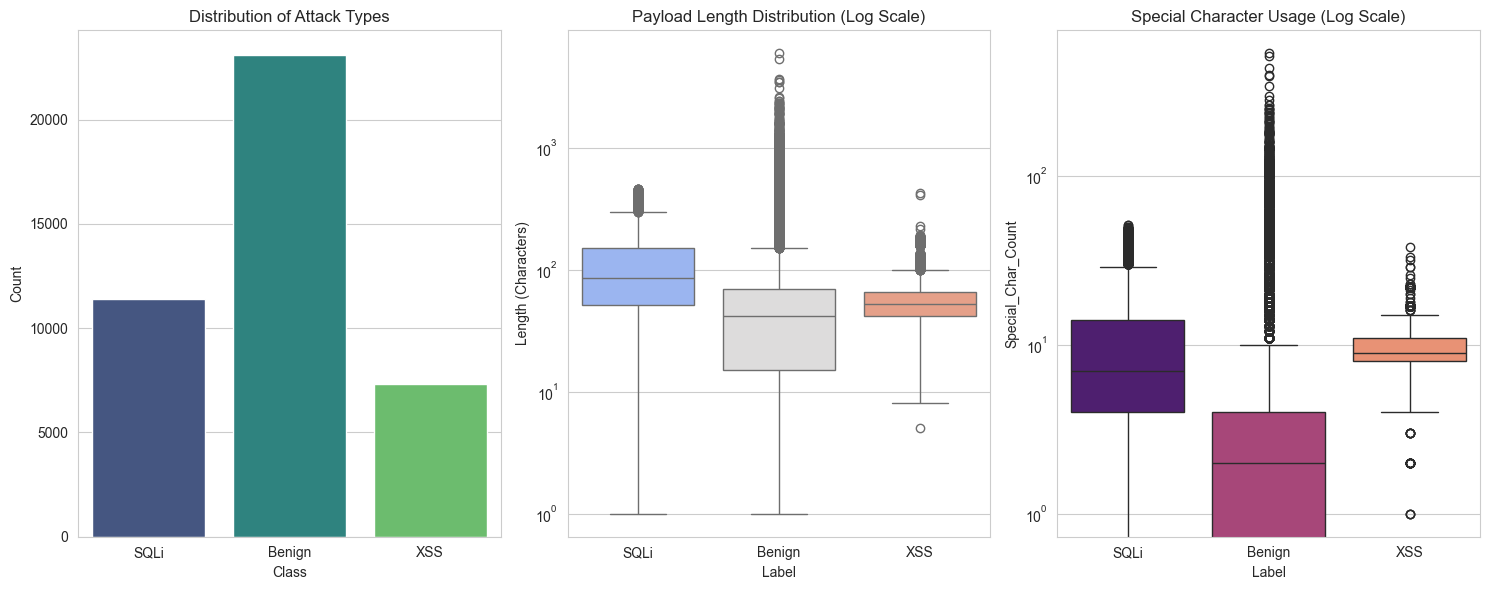


--- Top 10 4-grams for SQLi ---
'r ( ': 13174
' ) )': 11677
') ) ': 11677
'sele': 10010
'elec': 10009
'lect': 10009
'ect ': 10003
' ( 1': 9804
' sel': 9239
' ) |': 8503

--- Top 10 4-grams for XSS ---
'lert': 7222
'aler': 7220
'ert(': 7213
't(1)': 7137
'rt(1': 7135
'="al': 3960
'"ale': 3956
'(1)"': 3949
'test': 3378
'>tes': 3377


In [ ]:
SQLI_FILE = 'data/SQLiV3.csv'
XSS_FILE = 'data/XSS_dataset.csv'

df = load_and_clean_datasets(SQLI_FILE, XSS_FILE)

df = add_analysis_features(df)

print("\n Class Counts:")
print(df['Label'].value_counts())

print("\n Sample Data:")
print(df.head(5))

plot_eda(df)

analyze_ngrams(df, 'SQLi', n=4, top_k=10)
analyze_ngrams(df, 'XSS', n=4, top_k=10)
